In [1]:
# do all the needed imports
import pandas as pd
import json
import random
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.spatial as sp
import tensorflow_hub as hub
import tensorflow as tf
import abc
from typing import List
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

In [2]:
resp = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip")
zipfile = ZipFile(BytesIO(resp.read()))
lines: List = list()
for line in zipfile.open('SMSSpamCollection').readlines():
    lines.append(line.decode('utf-8'))
data = pd.DataFrame(data=lines)
new = data[0].str.split("\t", n = 1, expand = True)
data["text"]= new[1]
data["label"]= new[0]
data.drop(columns=[0], inplace = True)
data.drop_duplicates(subset="text", inplace=True)

In [3]:
# split data into train and test
train, test = train_test_split(data, test_size=0.2, random_state=42)
# let's select some sample from train set
initial_train = train.sample(frac=0.05, random_state=42)
initial_train.reset_index(drop=True, inplace=True)
# and create our unlabelled pool
pool = train[~train.index.isin(initial_train.index)]
pool.reset_index(drop=True, inplace=True)

Let's plot the class proportion.

In [6]:
class QueryStrategy(abc.ABC):
    @abc.abstractmethod
    def selection(self, *args, **kwargs):
        raise NotImplementedError


In [7]:
class RandomSelection(QueryStrategy):

    def selection(self, probs: np.ndarray, num_samples: int) -> List[int]:
        if probs.shape[0] >= num_samples:
            selection = np.random.choice(probs.shape[0], num_samples, replace=False)
        else:
            selection = np.arange(probs.shape[0])
        return selection

In [8]:
class MarginSelection(QueryStrategy):

    def selection(self, probs: np.ndarray, num_samples:int) -> List[int]:
        rev = np.sort(probs, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        if len(probs) >= num_samples:
            selection = np.argsort(values)[:num_samples]
        else:
            selection = np.argsort(values)
        return selection

In [9]:
class UncertainitySelection(QueryStrategy):

    def selection(self, probs: np.ndarray, num_samples: int, train_: pd.DataFrame, clf):
        train_["probs"] = clf.predict_proba(train_["text"])[:, 1]
        train_["decile"] = pd.cut(train_["probs"], 10)
        train_["preds"] = clf.predict(train_["text"])
        train_["uncer"] = train_.apply(lambda x: 1 if x["preds"] != x["label"] else 0, axis=1)
        train_["num_uncer"] = train_.groupby("decile")["uncer"].transform(lambda x: x.sum())
        uncer_inter = train_.iloc[train_["num_uncer"].argmax()]["decile"]
        mask = np.array([True if a in uncer_inter else False for a in probs[:, 1]])
        selection = mask.argsort()[-num_samples:]
        return selection

In [10]:
class EmbeddingSimilatitySelection(QueryStrategy):

     def selection(self, embedder, num_samples: int, train_: pd.DataFrame, pool_: pd.DataFrame):
        matrix1 = embedder(train_.query("label=='spam'")["text"].values).numpy()
        matrix2 = embedder(pool_["text"].values).numpy()
        res = 1 - sp.distance.cdist(matrix1, matrix2, 'cosine')
        col_max = np.amin(res, axis=0)
        selected_indices = np.argsort(col_max)[-num_samples:]
        return selected_indices

In [11]:
from typing import Callable, List, Any
from sklearn.metrics import f1_score
import inspect


class ActiveLearner:
    def __init__(self, test: pd.DataFrame, initial_train:pd.DataFrame, pool:pd.DataFrame,
                 classifier, batch_size: int = 10):
        self.batch_size: int = batch_size
        self.test: pd.DataFrame = test # test set
        self.train: pd.DataFrame = initial_train.copy() # train set
        self.pool: pd.DataFrame = pool.copy() # unlabeled pool
        self.classifier = classifier # classifier
        self.classifier.fit(self.train["text"], self.train["label"]) # fitting the classifier on initial train set
        self.calculated_metrics: List[float] = list() #define a list where we will put metrics from every iteration
        # store the metrics on 0 iteration
        self.calculated_metrics.append(f1_score(self.test["label"],
                                                self.classifier.predict(self.test["text"]),
                                                pos_label="spam"))

    def active_learning_cycle(self, iterations_num: int , selection_type: Any, embedder = None):
        for it in range(iterations_num):
            probs = self.classifier.predict_proba(self.pool["text"]) # make predictions on unlabelled pool
            args: List[str] = inspect.getfullargspec(selection_type.selection)[0]
            if len(args)==3:
                indexes = selection_type.selection(probs, self.batch_size) # get the indexes of data samples with query strategy
            elif embedder:
                indexes = selection_type.selection(embedder, self.batch_size, self.train, self.pool)
            else:
                indexes = selection_type.selection(probs, self.batch_size, self.train, self.classifier)
            new = self.pool[self.pool.index.isin(indexes)] # select data samples by indexes from pool
            self.train = pd.concat([self.train, new]) # as we already have labels, append labelled sample to train data
            self.train.reset_index(drop=True, inplace=True)
            self.pool.drop(indexes, inplace=True) # drop selected samples from ublabeled pool
            self.pool.reset_index(drop=True, inplace=True) # reset indexing
            self.classifier.fit(self.train["text"], self.train["label"]) # fit the classifier on updated train set
            preds = self.classifier.predict(self.test["text"]) # do the predictions on the test set
            self.calculated_metrics.append(f1_score(self.test["label"], preds, pos_label="spam")) # monitor choosen metric on test set

In [12]:
# calculate possible amount of iterations with given batch_size
iterations_num = int(pool.shape[0]/10)
# specify the classifier
classifier = Pipeline(
    steps=[
        ("tfidf", TfidfVectorizer()),
        ('clf', SGDClassifier(random_state=42)),])

# random sampling
random_cycle = ActiveLearner(test, initial_train, pool, classifier)
random_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = RandomSelection())

# margin sampling
margin_cycle = ActiveLearner(test, initial_train, pool, classifier)
margin_cycle.active_learning_cycle(iterations_num = iterations_num,
                                   selection_type = MarginSelection())

# most error in the bucket selection
Uncertain_cycle = ActiveLearner(test, initial_train, pool, classifier)
Uncertain_cycle.active_learning_cycle(iterations_num = iterations_num,
                                         selection_type = UncertainitySelection())

# text similarity selection
embeddingSimilarity_cycle = ActiveLearner(test, initial_train, pool, classifier)
embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddingSimilarity_cycle.active_learning_cycle(iterations_num = iterations_num,
                                     selection_type = EmbeddingSimilatitySelection(),
                                     embedder=embedder)

/tmp/ipython-input-3206791804.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_["num_uncer"] = train_.groupby("decile")["uncer"].transform(lambda x: x.sum())
/tmp/ipython-input-3206791804.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_["num_uncer"] = train_.groupby("decile")["uncer"].transform(lambda x: x.sum())
/tmp/ipython-input-3206791804.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_["

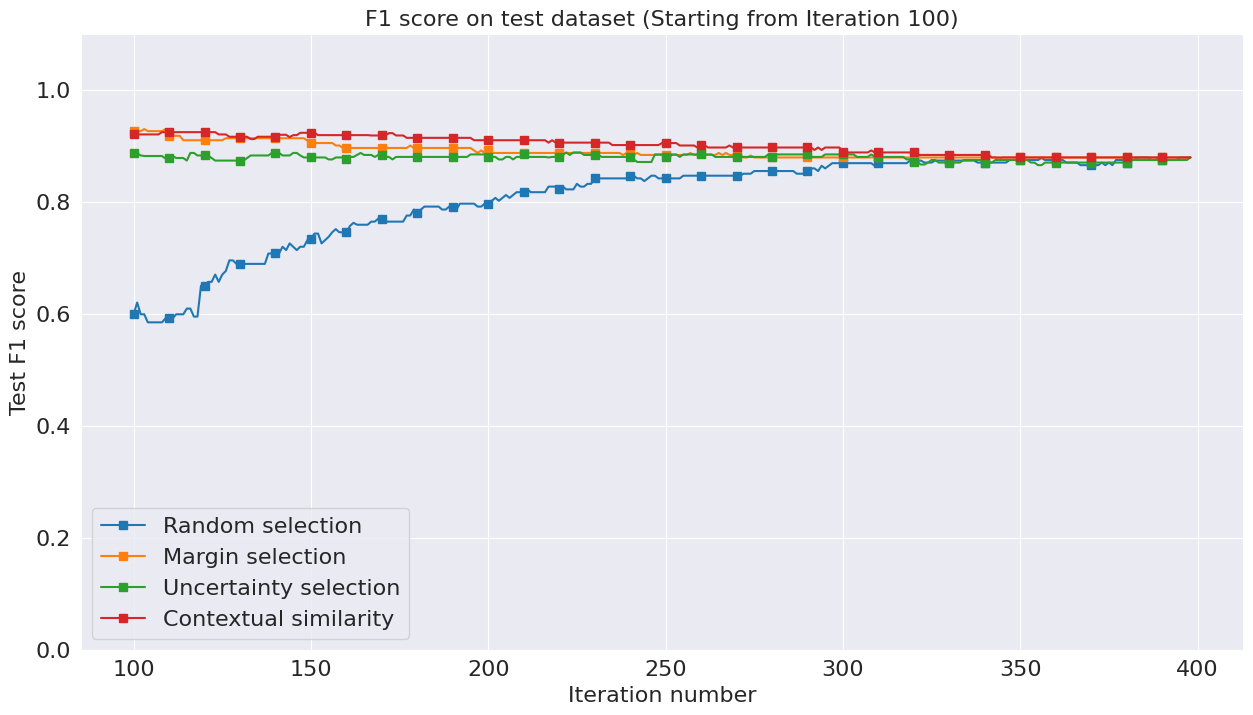

In [20]:
import matplotlib.pyplot as plt
import numpy as np

BIGGER_SIZE = 16
plt.figure(figsize=(15,8))
plt.rc('font', size=BIGGER_SIZE)
iterations = np.arange(0, iterations_num+1, 1)

# Slice data to exclude the first 100 points
start_idx = 100
if iterations_num > start_idx:
    x_vals = iterations[start_idx:]

    plt.title("F1 score on test dataset (Starting from Iteration 100)", fontsize=BIGGER_SIZE)
    plt.ylabel("Test F1 score", fontsize=BIGGER_SIZE)
    plt.xlabel("Iteration number")
    plt.ylim(0, 1.1)

    plt.plot(x_vals, random_cycle.calculated_metrics[start_idx:], label="Random selection", marker='s', markevery=10)
    plt.plot(x_vals, margin_cycle.calculated_metrics[start_idx:], label="Margin selection", marker='s', markevery=10)
    plt.plot(x_vals, Uncertain_cycle.calculated_metrics[start_idx:], label="Uncertainty selection", marker='s', markevery=10)
    plt.plot(x_vals, embeddingSimilarity_cycle.calculated_metrics[start_idx:], label="Contextual similarity",marker='s', markevery=10)

    plt.legend()
    plt.show()
else:
    print(f"Not enough iterations to skip 100. Total iterations: {iterations_num}")